# BRCA1 Expression Activation

BRCA1 is a tumor supressant gene related to various forms of breast cancer. A small molecule drug that increases BRCA1 activation could reduce tumor growth or make tumors more responsive to treatment.

This notebook reviews a BRCA1-expression bioassay and attempts to find small molecules that could be viable drug targets.

Bioassay data was obtained from PubChem: [QHTS Assay To Identify Small Molecule Activators Of BRCA1 Expression](https://pubchem.ncbi.nlm.nih.gov/bioassay/624202)

*Notebook created by Harrison Green*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.display import Image, HTML, display, SVG

In [3]:
from rdkit import Chem
from rdkit.Chem import rdFMCS, rdDepictor, Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole

In [4]:
import pubchempy as pcp

In [5]:
from bs4 import BeautifulSoup
import requests
import lxml

In [6]:
import time

In [7]:
from tqdm import tqdm

## BioAssay Data

Read the bioassay data into a Pandas data frame so we can work with it. The first 5 rows (not including the header) are column descriptors so we can skip them.

In [8]:
brca1_raw = pd.read_csv('data/AID_624202_datatable_active.csv', skiprows=[1,2,3,4,5])

# fetch some useful columns and clean up
brca1_all = brca1_raw[['PUBCHEM_CID', 'PUBCHEM_ACTIVITY_SCORE', 'Potency', 'Efficacy']]
brca1_all.columns = ['cid','score','potency','efficacy']
brca1_all.head()

,cid,score,potency,efficacy
0,644438,50,3.9811,223.335
1,644503,43,10.0000,100.714
2,645056,43,11.2202,143.083
3,645119,42,11.2202,103.173
4,645165,45,10.0000,185.571


Let's plot the score distribution to see what we're dealing with.

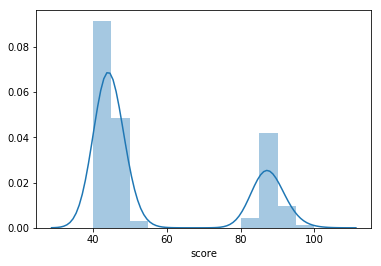

In [9]:
sns.distplot(brca1_all['score'])

This BioAssay gives a molecule the "active" status if the score is between 40 and 100. However, there is a clear spike around the score minimum which indicates that some of the molecules assigned an "active" phenotype are really not doing much at all. We can just filter these out and plot again.

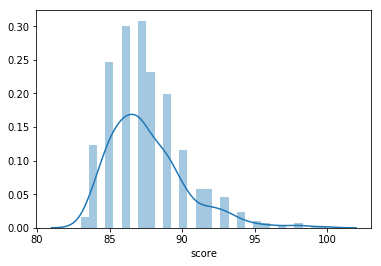

In [10]:
brca1_active = brca1_all[brca1_all['score'] > 60]
sns.distplot(brca1_active['score'])

This histogram looks more like what we would expect with a range of varying active molecules.

## Top Molecules

Let's look at the top 10 molecules and their scores:

In [11]:
brca1_active = brca1_active.sort_values(['score'],ascending=False)
brca1_active.head(10)

,cid,score,potency,efficacy
2643,844224,100,0.8913,296.791
1645,15991406,100,0.8913,256.432
3782,990823,99,1.7783,310.519
2772,977500,99,1.1220,235.957
1639,15987509,98,0.8913,242.718
2107,2150868,98,0.7943,160.406
3301,5054584,98,1.2589,268.722
1646,15991408,98,2.2387,262.622
2258,2317127,98,3.1623,359.905
2005,9567025,97,1.1220,255.743


## More data from PubChem

The cid doesn't mean much to us so let's get some more information.

Using the PubChemPy library, we can lookup these molecules by cid and get some useful stats like the smiles string, molecular weight and number of hydrogen acceptors and donors.

PubChem's usage policy requires that requests are rate limited to 5/second. So we will only fetch detailed information for the top 100 molecules.

(This will take about a minute to fetch all the data)

In [12]:
brca1_top = brca1_active.iloc[:100]

def fetch_info(cid):
    c = pcp.Compound.from_cid(cid)
    time.sleep(0.2) # rate limit requests
    return [
        c.canonical_smiles,
        c.molecular_weight,
        c.h_bond_acceptor_count,
        c.h_bond_donor_count,
        c.xlogp
    ]

brca1_pc = pd.DataFrame(columns=['smiles','weight','h_acceptor','h_donor','xlogp'])

for idx, row in tqdm(brca1_top.iterrows(), desc="PubChem data", total=100):
    brca1_pc.loc[idx] = fetch_info(int(row['cid']))

brca1_top_pc = brca1_top.join(brca1_pc)
brca1_top_pc.head()

PubChem data: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


,cid,score,potency,efficacy,smiles,weight,h_acceptor,h_donor,xlogp
2643,844224,100,0.8913,296.791,CC1=CC=C(O1)C(=O)NC2=NC3=C(S2)C=C(C=C3)Cl,292.737,4,1,4
1645,15991406,100,0.8913,256.432,C1=CC(=CC=C1CC2=CN3C=C(N=C3S2)C4=CC=C(C=C4)Cl)F,342.816,3,0,6.2
3782,990823,99,1.7783,310.519,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC=C(C=C3)Br,366.277,4,1,3.1
2772,977500,99,1.1220,235.957,COC1=CC=C(C=C1)NC(=O)NC(=O)C2=CC=CC=C2,270.288,3,2,3.4
1639,15987509,98,0.8913,242.718,CC1=CC=C(C=C1)OCC(=O)NC2=CC=C(C=C2)C3=NC4=C(O3...,372.424,4,1,5


## Visualizations with RDKit

Let's display the 2D molecular structure of the top 100 compounds using rdkit and some html.

In [13]:
def display_molecules(df, width='10%', scale='2'):
    def get_mol(df):
        return Chem.MolFromSmiles(df['smiles'])

    def get_legend(df):
        return str(df['score'])

    def write_svg_image(mol, fpath):
        drawer = rdMolDraw2D.MolDraw2DSVG(400,400)
        rdDepictor.Compute2DCoords(mol)
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()

        open(fpath, 'w').write(svg)

    s = ""

    for idx, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        fpath = 'img/render_%d.svg' % row['cid']
        write_svg_image(mol, fpath)

        s += "<img class='zoom1' style='width:%s;display:inline-block;' src='%s'/>" % (width, fpath)

    s += """
    <style>
    .zoom1 {
        transition: all 0.3s;
        border: 1px solid #fff;
    }
    .zoom1:hover {
        transform:scale(%s);
        border-color: #aaa;
    }
    </style>
    """ % scale

    display(HTML(s))

In [14]:
display_molecules(brca1_top_pc)

## Known Protein Targets

In order to make sure that the small molecules here have no known protein target, we can search various compound databases such as BindingDB.

Specifically, BindingDB provides an api that allows us to search by a SMILES string and similarity coefficient. We will search for known targets for all 100 of our top molecules and store the top 5 most similar molecules with known targets (if any exist).

This method will allow us to filter out molecules that have known targets or molecules that are very similar to molecules with known targets.

We will also keep track of some metadata such as:
* number of hits in BindingDB (not necessarily exact matches)
* number of known targets (count where `tanimoto == 1`)
* max tanimoto (max of `tanimoto`)
* number of known human targets (count where `species == human`, `tanimoto == 1`)
* max tanimoto for human targets (max of `tanimoto` where `species == human`)

In [15]:
bindingDB_endpoint = "http://www.bindingdb.org/axis2/services/BDBService/getTargetByCompound"

def search_targets(smiles):
    params = {
        'smiles': smiles,
        'cutoff': 0.85
    }
    
    r = requests.get(bindingDB_endpoint, params=params)
    b = BeautifulSoup(r.text, 'xml')
    
    meta_err = [-1,-1,-1,-1,-1] + ([''] * 20)
    
    # number of hits
    num_hits = int(b.find('bdb:hit').string)
    if num_hits == 0:
        return [0,0,0,0,0] + ([''] * 20)
    
    # catch parsing errors
    try:
        # enumerate hits
        hits = b.find_all('bdb:affinities')

        targets = pd.DataFrame()

        for h in hits:
            ht = [[
                h.find('bdb:monomerid').string,
                h.find('bdb:target').string,
                h.find('bdb:species').string,
                h.find('bdb:affinity_type').string,
                h.find('bdb:affinity').string,
                h.find('bdb:smiles').string,
                float(h.find('bdb:tanimoto').string)
            ]]
            targets = targets.append(ht)

        targets.columns = ['monomerid','target','species','affinity_type','affinity','smiles','tanimoto']

        targets['is_human'] = targets['species'].apply(lambda k: 'Homo sapiens' in k)
        
        targets = targets.sort_values(['tanimoto', 'is_human'], ascending=[0,0])

        # pick the top 5 targets (by tanimoto coefficient) and consolidate
        sp_targets = targets.apply(lambda t: pd.Series([t['target'], t['smiles'], t['tanimoto'], t['species']]), axis=1)
        sp_targets = sp_targets.iloc[:5]
        
        sp_list = list(sp_targets.values.flatten())
        sp_list += ([''] * (20 - len(sp_list))) # pad with empty strings if fewer than 5 targets found

        # generate ligands
        
        meta = [
            num_hits,
            sum(targets['tanimoto'] == 1),
            max(targets['tanimoto']),
            sum(targets['is_human'] & (targets['tanimoto'] == 1)),
            max(targets[targets['is_human']]['tanimoto']) if sum(targets['is_human']) > 0 else 0
        ]
        
        meta += sp_list
        
        return meta
    except Exception as e:
        import traceback
        traceback.print_exc()
        return meta_err

This will take about 5 minutes to run:

In [16]:
meta = pd.DataFrame(columns=[
    'num_hits',
    'exact_targets',
    'closest_target',
    'exact_targets_human',
    'closest_target_human',
    't_target_1', # name of target
    't_ligand_1', # smiles string of ligand
    't_tanimoto_1', # tanimoto coefficient of this ligand with respect to the molecule
    't_species_1', # species in which the target exists
    't_target_2',
    't_ligand_2',
    't_tanimoto_2',
    't_species_2',
    't_target_3',
    't_ligand_3',
    't_tanimoto_3',
    't_species_3',
    't_target_4',
    't_ligand_4',
    't_tanimoto_4',
    't_species_4',
    't_target_5',
    't_ligand_5',
    't_tanimoto_5',
    't_species_5'
])

for idx, row in tqdm(brca1_top_pc.iterrows(), desc="BindingDB data", total=100):
    meta.loc[idx] = search_targets(row['smiles'])

brca1_top_binding = brca1_top_pc.join(meta)
brca1_top_binding.head()

BindingDB data: 100%|██████████| 100/100 [06:03<00:00,  3.64s/it]


,cid,score,potency,efficacy,smiles,weight,h_acceptor,h_donor,xlogp,num_hits,...,t_tanimoto_3,t_species_3,t_target_4,t_ligand_4,t_tanimoto_4,t_species_4,t_target_5,t_ligand_5,t_tanimoto_5,t_species_5
2643,844224,100,0.8913,296.791,CC1=CC=C(O1)C(=O)NC2=NC3=C(S2)C=C(C=C3)Cl,292.737,4,1,4,12,...,1,Homo sapiens,SUMO/sentrin specific peptidase family member 8,Clc1ccc2nc(NC(=O)c3ccco3)sc2c1,0.94361,Homo sapiens,Nuclear factor NF-kappa-B,Clc1ccc2nc(NC(=O)c3ccco3)sc2c1,0.94361,Homo sapiens (Human)
1645,15991406,100,0.8913,256.432,C1=CC(=CC=C1CC2=CN3C=C(N=C3S2)C4=CC=C(C=C4)Cl)F,342.816,3,0,6.2,0,...,,,,,,,,,,
3782,990823,99,1.7783,310.519,C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC=C(C=C3)Br,366.277,4,1,3.1,4,...,0.88496,Mus musculus,Zinc finger protein GLI1,Brc1ccc(cc1)-c1csc(n1)N1CCCCCC1,0.88496,Mus musculus,,,,
2772,977500,99,1.1220,235.957,COC1=CC=C(C=C1)NC(=O)NC(=O)C2=CC=CC=C2,270.288,3,2,3.4,2,...,,,,,,,,,,
1639,15987509,98,0.8913,242.718,CC1=CC=C(C=C1)OCC(=O)NC2=CC=C(C=C2)C3=NC4=C(O3...,372.424,4,1,5,50,...,0.87085,Homo sapiens (Human),Cholesteryl ester transfer protein,COc1ccc2nc(oc2c1)-c1ccc(NC(=O)COc2ccccc2C)cc1,0.86545,Homo sapiens (Human),Cholesteryl ester transfer protein,Cc1ccc(OCC(=O)Nc2ccc(cc2)-c2nc3cc(C)cc(C)c3o2)cc1,0.86022,Homo sapiens (Human)


## Similar targets

Now that we have some information about which compounds/species certain molecules will target, we can display the top 100 molecules along with some information about related molecules with known targets.

Additionally, we can use RDKit to compute the MCS (maximum common substructure) and then highlight it in order to provide an indication of the similarities between our small molecule and ligands with known targets.

In [17]:
def mol_or_none(smiles):
    if smiles != '':
        return Chem.MolFromSmiles(smiles)
    else:
        return None

def fetch_molecule_and_related(row):
    sm = mol_or_none(row['smiles'])
    t1 = mol_or_none(row['t_ligand_1'])
    t2 = mol_or_none(row['t_ligand_2'])
    t3 = mol_or_none(row['t_ligand_3'])
    t4 = mol_or_none(row['t_ligand_4'])
    t5 = mol_or_none(row['t_ligand_5'])
    
    return [sm,t1,t2,t3,t4,t5]
    
def get_highlight(mols):
    highlight = [[]]
    
    for i in range(1,6):
        if mols[i] != None:
            match = rdFMCS.FindMCS([mols[i], mols[0]])
            match_c = Chem.MolFromSmarts(match.smartsString)
            highlight.append(mols[i].GetSubstructMatch(match_c))
        else:
            highlight.append([])
    
    return highlight

def write_svg_image(mol, highlight, fpath):
    drawer = rdMolDraw2D.MolDraw2DSVG(400,400)
    rdDepictor.Compute2DCoords(mol)
    drawer.DrawMolecule(mol, highlightAtoms=highlight)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    open(fpath, 'w').write(svg)
        
def display_row(row, idx):
    # load and render ligand moleculse
    mols = fetch_molecule_and_related(row)
    highlight = get_highlight(mols)    
    
    num = len(filter(lambda k: k is not None, mols))
    
    # save images
    for i in range(num):
        fpath = 'img/render_%d_%d.svg' % (row['cid'], i)
        write_svg_image(mols[i], highlight[i], fpath)
    
    s = ''
    
    s += "<tr>"
    
    s += "<td><h2>%d</h2></td>" % (idx)
    
    s += "<td style='border-right:3px solid #aaa;vertical-align:top;'>"
    s += "<img class='zoom2' src='img/render_%d_0.svg'></img>" % (row['cid'])
    s += "<p style='text-align:left;'><b>%d</b></p>" % row['cid']
    s += "<p style='text-align:left;'>Score: <b>%d</b></p>" % row['score']
    s += "<p style='text-align:left;'>Potency: <b>%.2f</b></p>" % row['potency']
    s += "<p style='text-align:left;'>Efficacy: <b>%.2f</b></p>" % row['efficacy']
    s += "<p style='text-align:left;'>Weight: <b>%.2f</b></p>" % row['weight']
    s += "<p style='text-align:left;'>H-Acceptors: <b>%d</b></p>" % row['h_acceptor']
    s += "<p style='text-align:left;'>H-Donors: <b>%d</b></p>" % row['h_donor']
    s += "</td>"
    
    if row['t_target_1'] == '':
        s += "<td>"
        s += "<h3 style='text-align:left;'>No targets found</h3>"
        s += "</td>"
        s += "<td></td>" * 4
    else:
        for i in range(1,6):
            if i < num:
                s += "<td style='vertical-align:top;'>"
                s += "<img class='zoom2' src='img/render_%d_%d.svg'></img>" % (row['cid'], i)
                s += "<p style='text-align:left;'>Similarity: <b>%s</b></p>" % row['t_tanimoto_' + str(i)]
                s += "<p style='text-align:left;'>Target: <b>%s</b></p>" % row['t_target_' + str(i)]
                s += "<p style='text-align:left;'>Ligands: <b>%s</b></p>" % row['t_species_' + str(i)]
                s += "</td>"
            else:
                s += "<td></td>"
        
    s += "</tr>"
        
    return s
    
    
s = ''
s += "<table style='border: 3px solid #aaa;'>"

s += "<tr>"
s += "<td style='border-bottom: 3px solid #aaa; text-align:center;' colspan=2><h2>Compound</h2></td>"
s += "<td style='border-bottom: 3px solid #aaa; text-align:center;' colspan=5><h2>Ligands</h2></td>"
s += "</tr>"

for i in range(100):
    s += display_row(brca1_top_binding.iloc[i], i)

s += "</table>"

s += """
<style>
.zoom2 {
    transition: all 0.3s;
    border: 1px solid #fff;
}
.zoom2:hover {
    transform:scale(1.5);
    border-color: #aaa;
}
</style>
"""

display(HTML(s))

## Lipinski's Rule

Additionally, we can calculate whether these molecules satisfy Lipinski's rule of five for a viable oral drug. A molecule satisfies these rules if it contains no more than one exception to the following conditions:

* no more than 5 hydrogen bond donors
* no more than 10 hydrogen bond acceptors
* a molecular mass less than 500 daltons
* an octanol-water partitian coefficient no greater than 5

In [18]:
def satisfies_lipinski(h_donors, h_acceptors, mass, logp):
    r1 = h_donors <= 5
    r2 = h_acceptors <= 10
    r3 = mass < 500
    r4 = logp < 5
    
    return sum([r1,r2,r3,r4]) >= 3

In [19]:
brca1_lipinski = pd.DataFrame(columns=['lipinski'])

for idx, row in brca1_top_binding.iterrows():
    brca1_lipinski.loc[idx] = satisfies_lipinski(row['h_donor'], row['h_acceptor'], row['weight'], row['xlogp'])

brca1_top_lipinski = brca1_top_binding.join(brca1_lipinski)

## Filtering

Let's keep only molecules that don't have any known targets.

In [20]:
brca1_filter = brca1_top_lipinski[brca1_top_lipinski['exact_targets'] == 0]
print len(brca1_filter)

65


Now let's filter out molecules that don't satisfy the Lipinski rule.

In [21]:
brca1_filter = brca1_filter[brca1_filter['lipinski']]
print len(brca1_filter)

65


There was no size change, so all the molecules satisfy the rule.

Now, let's filter out molecules with a similar structure to molecules that target human compounds.

In [22]:
brca1_filter = brca1_filter[brca1_filter['closest_target_human'] > 0]
print len(brca1_filter)

29


We are left with 29 out of the top 100 molecules. Let's visualize them.

In [23]:
display_molecules(brca1_filter, width='20%', scale='1.5')

At first glance, it looks like there is quite a bit of diversity in these molecules.

We will pick the top ten compounds and clean up the information a bit:

In [24]:
brca1_final = brca1_filter.iloc[:10][['smiles', 'weight', 'h_acceptor', 'h_donor', 'xlogp', 'score', 'potency', 'efficacy']]
brca1_final.to_csv('data/final.csv', index=False)
print brca1_final

                                                 smiles   weight h_acceptor  \
3782         C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC=C(C=C3)Br  366.277          4   
2772             COC1=CC=C(C=C1)NC(=O)NC(=O)C2=CC=CC=C2  270.288          3   
1639  CC1=CC=C(C=C1)OCC(=O)NC2=CC=C(C=C2)C3=NC4=C(O3...  372.424          4   
2107  CC1=C2C(=C(C=C1)OC)N(C(=NC(=O)C3=CC=C(C=C3)C(=...  354.424          4   
3301        C1COCCN1C(=O)C2=NOC(=C2)C3=CC(=C(C=C3)Cl)Cl  327.161          4   
618      CC1CN(CC(O1)C)C2=NC=NC3=C2C=NN3C4=CC=C(C=C4)Cl  343.815          5   
3705  CN1C(=CC2=C(C1=O)C(=NO2)C3=C(C=CC=C3Cl)F)C4=CC...  372.756          5   
2592  C1COC2=C(O1)C=CC(=C2)C(=O)COC3=NC=NC4=C3C=CC(=...  356.762          6   
22               C1=CC=C(C(=C1)CSC2=NN=C(O2)C3=CC=CS3)F  292.346          6   
268   C1CCCC2(CC1)C(=O)N(C(=O)N2)CC(=O)C3=CC4=C(C=C3...  358.394          5   

     h_donor xlogp  score  potency  efficacy  
3782       1   3.1     99   1.7783   310.519  
2772       2   3.4     99   1.1220  